In [1]:
import os
import pickle
from typing import Optional

import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from transformers.modelcard import parse_log_history

/home/abthuy/Documents/PhD research/qdet-comparison/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##### INPUTS #####
dataset_name = "race_pp_4000"
seed = 123
model_name = "DistilBERT"
encoding = "question_all"

## Test metrics

In [3]:
def get_metrics(dataset_name: str, model_name: str, encoding: Optional[str], seed: Optional[int]) -> pd.DataFrame:
    """Read metrics from output directory and return as a dataframe."""
    if seed is None:
        output_dir = os.path.join('output', dataset_name)
    else:
        output_dir = os.path.join('output', dataset_name, 'seed_' + str(seed))

    if encoding is None:
        metrics = pd.read_csv(os.path.join(output_dir, 'eval_metrics_' + model_name + '.csv'))
    else:
        metrics = pd.read_csv(os.path.join(output_dir, 'eval_metrics_' + model_name + '_' + encoding + '.csv'))
    metrics = metrics.transpose().reset_index().rename(columns={'index': 'metric', 0: 'value'})
    return metrics

metrics = get_metrics(dataset_name, model_name, encoding, seed)
metrics

,metric,value
0,test_mean_absolute_error,0.203474
1,train_mean_absolute_error,0.142250
2,test_root_mean_squared_error,0.459258
3,train_root_mean_squared_error,0.381554
4,test_r2_score,0.419530
5,train_r2_score,0.781625
6,test_spearman_rho,0.732971
7,train_spearman_rho,0.889154
8,test_pearson_rho,0.735854
9,train_pearson_rho,0.888825


## Training logs

In [4]:
def get_train_logs(dataset_name: str, model_name: str, encoding: str, seed: int) -> tuple:
    """Read training logs from output directory and return as a dictionary."""
    output_dir = os.path.join('output', dataset_name, 'seed_' + str(seed))

    with open(os.path.join(output_dir, model_name + '_' + encoding, "train_logs.pickle"), 'rb') as handle:
        logs = pickle.load(handle)
    train_log, lines, eval_results = parse_log_history(logs)  # NOTE: func from transformers.modelcard
    return train_log, lines, eval_results

train_log, lines, eval_results = get_train_logs(dataset_name, model_name, encoding, seed)

print("="*3, "train_log", "="*3)
pprint(train_log)
print("="*3, "lines", "="*3)
pprint(lines)
print("="*3, "eval_results", "="*3)
pprint(eval_results)

=== train_log ===
{'epoch': 6.0,
 'step': 4500,
 'total_flos': 4768741306368000.0,
 'train_loss': 0.0815886976453993,
 'train_runtime': 726.9752,
 'train_samples_per_second': 165.068,
 'train_steps_per_second': 10.317}
=== lines ===
[{'Epoch': 1.0,
  'Mae': {'mae': 0.294243288725344},
  'Mse': {'mse': 0.15641633789843853},
  'Pearsonr': {'pearsonr': 0.780579867997856},
  'R Squared': 0.574,
  'Step': 750,
  'Training Loss': 0.2201,
  'Validation Loss': 0.15641634166240692},
 {'Epoch': 2.0,
  'Mae': {'mae': 0.27968226951915365},
  'Mse': {'mse': 0.16166100224675842},
  'Pearsonr': {'pearsonr': 0.7668064180817376},
  'R Squared': 0.559,
  'Step': 1500,
  'Training Loss': 0.1184,
  'Validation Loss': 0.16166101396083832},
 {'Epoch': 3.0,
  'Mae': {'mae': 0.2432930216417006},
  'Mse': {'mse': 0.16016688225140405},
  'Pearsonr': {'pearsonr': 0.7698772853335638},
  'R Squared': 0.563,
  'Step': 2250,
  'Training Loss': 0.0677,
  'Validation Loss': 0.1601668745279312},
 {'Epoch': 4.0,
  'Mae'

In [5]:
def remove_nesting(logs: list[dict[str, float]]) -> list[dict[str, float]]:
    """Remove unnecessary nesting from logs."""
    new_logs = []
    for log_epoch in logs:
        tmp_dict = {}
        for key, value in log_epoch.items():
            if isinstance(value, dict):
                nested_keys = list(value.keys())
                if len(nested_keys) == 1 and key.lower() == nested_keys[0]:
                    tmp_dict[key] = value[nested_keys[0]]
            else:
                tmp_dict[key] = value
        new_logs.append(tmp_dict)
    return new_logs


all_logs = remove_nesting(lines)
pprint(all_logs)

[{'Epoch': 1.0,
  'Mae': 0.294243288725344,
  'Mse': 0.15641633789843853,
  'Pearsonr': 0.780579867997856,
  'R Squared': 0.574,
  'Step': 750,
  'Training Loss': 0.2201,
  'Validation Loss': 0.15641634166240692},
 {'Epoch': 2.0,
  'Mae': 0.27968226951915365,
  'Mse': 0.16166100224675842,
  'Pearsonr': 0.7668064180817376,
  'R Squared': 0.559,
  'Step': 1500,
  'Training Loss': 0.1184,
  'Validation Loss': 0.16166101396083832},
 {'Epoch': 3.0,
  'Mae': 0.2432930216417006,
  'Mse': 0.16016688225140405,
  'Pearsonr': 0.7698772853335638,
  'R Squared': 0.563,
  'Step': 2250,
  'Training Loss': 0.0677,
  'Validation Loss': 0.1601668745279312},
 {'Epoch': 4.0,
  'Mae': 0.2562246043129855,
  'Mse': 0.19023282442606926,
  'Pearsonr': 0.756289929746914,
  'R Squared': 0.482,
  'Step': 3000,
  'Training Loss': 0.0398,
  'Validation Loss': 0.19023284316062927},
 {'Epoch': 5.0,
  'Mae': 0.2576882350852561,
  'Mse': 0.19862377556209024,
  'Pearsonr': 0.7371610587412822,
  'R Squared': 0.459,
  'St

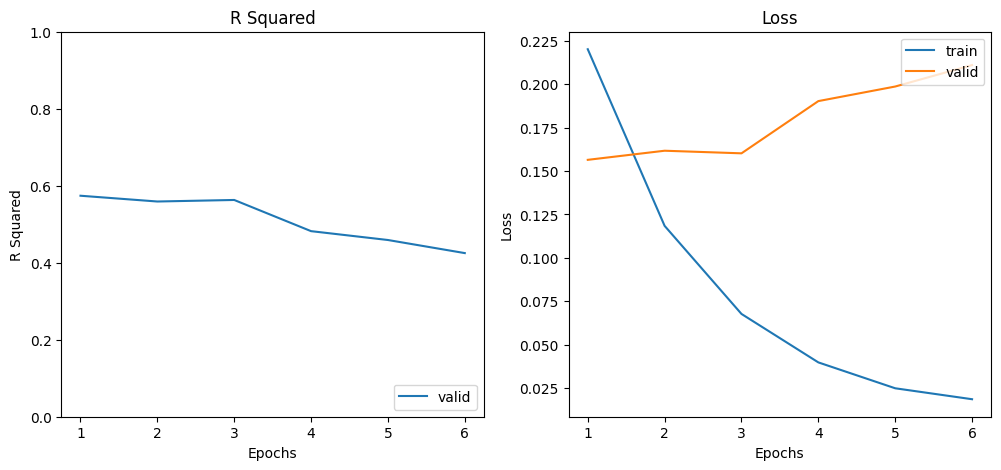

In [6]:
def plot_history(all_logs: list[dict[str, float]], metric: str) -> None:
    """Plot metric and loss in function of number of epochs.
    Parameters
    ----------
    all_logs : list[dict[str, float]]
        List of dictionaries containing the training logs for each epoch.
    metric : str
        Metric to plot (in addition to loss).
    """
    
    epochs_arr = [log_epoch['Epoch'] for log_epoch in all_logs]
    train_loss_arr = [log_epoch['Training Loss'] for log_epoch in all_logs]
    val_loss_arr = [log_epoch['Validation Loss'] for log_epoch in all_logs]
    metric_arr = [log_epoch[metric] for log_epoch in all_logs]

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs_arr, metric_arr)
    plt.ylim(0, 1)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('Epochs')
    plt.legend(['valid'], loc='lower right')

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs_arr, train_loss_arr)
    plt.plot(epochs_arr, val_loss_arr)
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc='upper right')

    plt.show()

metric = "R Squared"
plot_history(all_logs, metric)